Download DOGE data from [yahoo](https://finance.yahoo.com/quote/DOGE-USD/history?period1=1546300800&period2=1657756800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) | {'rt'}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Semon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data loading

In [3]:
ticker_df_path = 'data/DOGE-USD.csv'
# ticker_df_path = 'data/BTC-USD.csv'
# ticker_df_path = 'data/TSLA.csv'
# ticker_df_path = 'data/CNY=X.csv'

tweets_df_path = 'data/elon_prepared_tweets.csv'
# tweets_df_path = 'data/trump_prepared_tweets.csv'

In [4]:
ticker_df = pd.read_csv(ticker_df_path)
ticker_df.Date = pd.to_datetime(ticker_df.Date)
ticker_df.set_index('Date', drop=True, inplace=True)
ticker_df['NextDayClose'] = ticker_df.Close.shift(-1)
ticker_df = ticker_df.reindex(
    pd.date_range(
        '2019-01-01', 
        ticker_df.index.max()
    ),
    method='backfill',
)
ticker_df.head()

,Open,High,Low,Close,Adj Close,Volume,NextDayClose
2019-01-01,0.002346,0.002392,0.002322,0.002392,0.002392,17364744,0.002407
2019-01-02,0.002388,0.002458,0.002372,0.002407,0.002407,18015392,0.002360
2019-01-03,0.002404,0.002414,0.002356,0.002360,0.002360,17619234,0.002315
2019-01-04,0.002364,0.002397,0.002274,0.002315,0.002315,19530100,0.002319
2019-01-05,0.002320,0.002350,0.002280,0.002319,0.002319,17148586,0.002328


In [5]:
ticker_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1319 entries, 2019-01-01 to 2022-08-11
Freq: D
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1319 non-null   float64
 1   High          1319 non-null   float64
 2   Low           1319 non-null   float64
 3   Close         1319 non-null   float64
 4   Adj Close     1319 non-null   float64
 5   Volume        1319 non-null   int64  
 6   NextDayClose  1318 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.4 KB


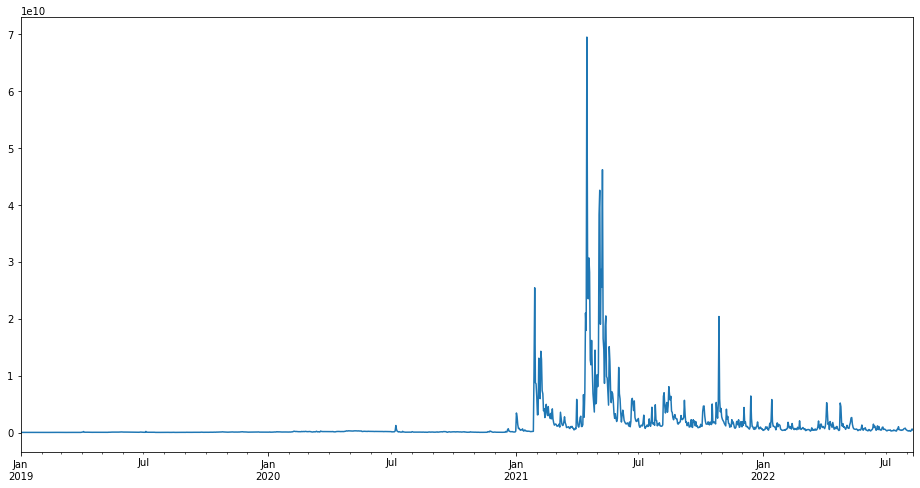

In [6]:
ticker_df.Volume.plot(figsize=(16, 8));

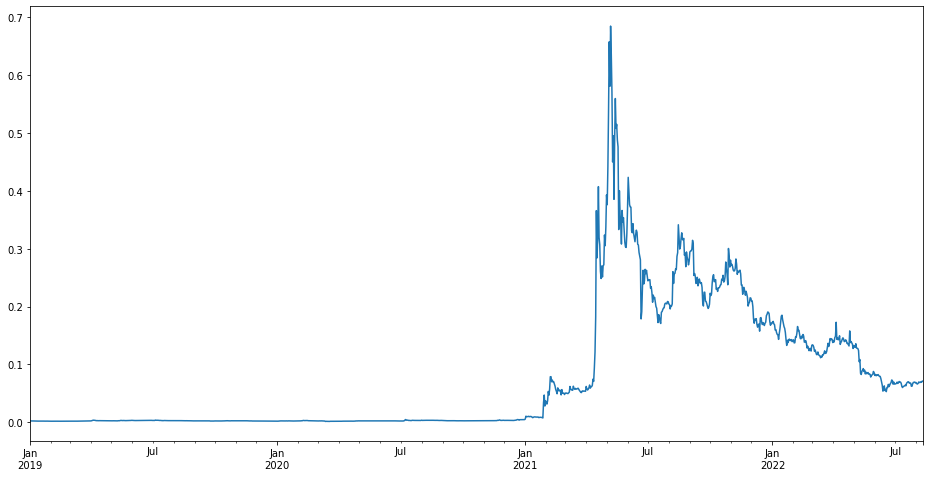

In [7]:
ticker_df.Close.plot(figsize=(16, 8));

In [8]:
tweets_df = pd.read_csv(tweets_df_path, index_col='id', parse_dates=['date'])
tweets_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,this is a pretty awful lie i left south africa...,-0.048342,-0.014244,0.016088,0.002211,-0.012234,0.082633,-0.016118,...,-0.000773,-0.019107,-0.039366,0.015982,0.049104,-0.056251,-0.057072,-0.057435,-0.011789,0.036748
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,this person blocked me so can t read the tweet...,-0.012730,-0.017078,0.028585,0.025572,-0.045578,0.065623,-0.013617,...,-0.012550,-0.046741,-0.000691,0.019577,0.077184,-0.057226,-0.047901,0.028700,0.011547,0.033419
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,we started zip2 with 2k from me plus my overcl...,-0.042071,-0.075559,-0.029521,0.020394,-0.014714,0.073634,-0.013487,...,-0.022040,-0.001922,-0.011946,0.028490,0.086696,-0.028041,-0.038507,-0.005319,0.075069,-0.058273
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,he didn t own an emerald mine i worked my way ...,-0.026122,-0.068418,0.031035,-0.038473,-0.031547,0.080213,-0.034022,...,0.003521,-0.032675,-0.035726,-0.006440,0.051075,-0.005771,-0.002485,-0.073661,-0.000422,0.012104
1211051740562366464,@geofficient Pretty much,2019-12-28,pretty much,-0.061854,-0.111202,0.020066,0.037324,-0.120143,0.163722,-0.013768,...,0.025169,-0.046883,-0.015783,0.062415,0.068658,-0.104441,-0.167005,0.059559,0.263472,0.011272


In [9]:
# tweets_df = tweets_df[tweets_df.cleared_text.str.contains('doge')]

In [10]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8643 entries, 1211071324518531072 to 1344810193952014336
Columns: 303 entries, text to V300
dtypes: datetime64[ns](1), float64(300), object(2)
memory usage: 20.0+ MB


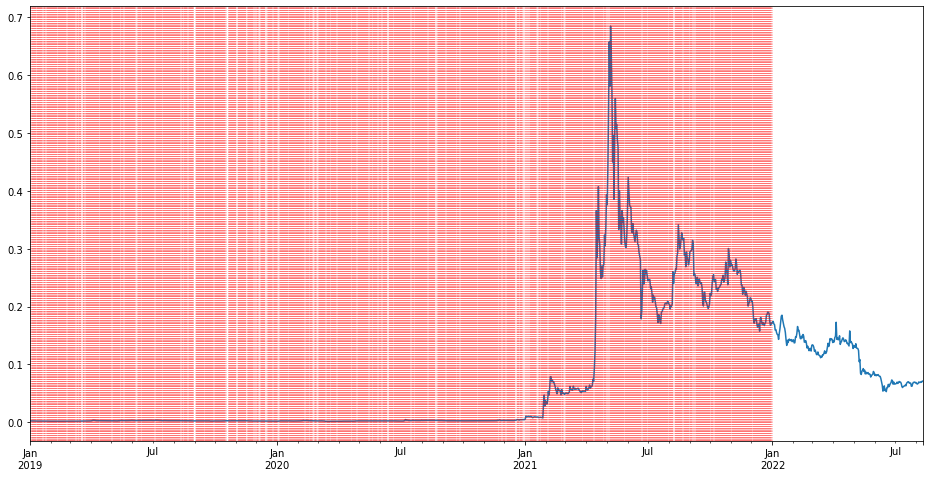

In [11]:
ticker_df.Close.plot(figsize=(16, 8));
for xc in set(tweets_df.date): # [tweets_df.cleared_text.str.contains('doge')]
    plt.axvline(x=xc, color='red', dashes=(0.2, 1))

In [12]:
tweets_df['ticker_grow_in_this_day'] = tweets_df.apply(
    lambda r: ticker_df.loc[r['date']], 
    axis=1
).apply(
    lambda r: np.int32(r.Open > r.NextDayClose), 
    axis=1
)

In [13]:
tweets_df['ticker_grow_in_this_day'].mean()

0.5205368506305681

In [14]:
tweets_df.head()

,text,date,cleared_text,V1,V2,V3,V4,V5,V6,V7,...,V292,V293,V294,V295,V296,V297,V298,V299,V300,ticker_grow_in_this_day
id,,,,,,,,,,,,,,,,,,,,,
1211071324518531072,@Joe__Wakefield @austinbarnard45 @tjq1190 @tyg...,2019-12-28,this is a pretty awful lie i left south africa...,-0.048342,-0.014244,0.016088,0.002211,-0.012234,0.082633,-0.016118,...,-0.019107,-0.039366,0.015982,0.049104,-0.056251,-0.057072,-0.057435,-0.011789,0.036748,0
1211069054779301894,@austinbarnard45 @tjq1190 @tyger_cyber @fawful...,2019-12-28,this person blocked me so can t read the tweet...,-0.012730,-0.017078,0.028585,0.025572,-0.045578,0.065623,-0.013617,...,-0.046741,-0.000691,0.019577,0.077184,-0.057226,-0.047901,0.028700,0.011547,0.033419,0
1211064937004589056,@IrinaAntony @tjq1190 @tyger_cyber @fawfulfan ...,2019-12-28,we started zip2 with 2k from me plus my overcl...,-0.042071,-0.075559,-0.029521,0.020394,-0.014714,0.073634,-0.013487,...,-0.001922,-0.011946,0.028490,0.086696,-0.028041,-0.038507,-0.005319,0.075069,-0.058273,0
1211054942192119808,@tjq1190 @tyger_cyber @fawfulfan @_Mikemo He d...,2019-12-28,he didn t own an emerald mine i worked my way ...,-0.026122,-0.068418,0.031035,-0.038473,-0.031547,0.080213,-0.034022,...,-0.032675,-0.035726,-0.006440,0.051075,-0.005771,-0.002485,-0.073661,-0.000422,0.012104,0
1211051740562366464,@geofficient Pretty much,2019-12-28,pretty much,-0.061854,-0.111202,0.020066,0.037324,-0.120143,0.163722,-0.013768,...,-0.046883,-0.015783,0.062415,0.068658,-0.104441,-0.167005,0.059559,0.263472,0.011272,0


In [15]:
words_on_grow_df = pd.DataFrame({
    'words': tweets_df.cleared_text.str.split().apply(set),
    'ticker_grow_in_this_day': tweets_df.ticker_grow_in_this_day,
}).explode('words')

words_in_tweets = pd.DataFrame({
    'tweets_ratio': words_on_grow_df.groupby('words')['ticker_grow_in_this_day'].count() / len(tweets_df),
    'tweets_grow_ratio': (
        words_on_grow_df.query('ticker_grow_in_this_day == 1').groupby('words')['ticker_grow_in_this_day'].count() 
        / len(tweets_df.query('ticker_grow_in_this_day == 1'))
    ),
    'tweets_fall_ratio': (
        words_on_grow_df.query('ticker_grow_in_this_day == 0').groupby('words')['ticker_grow_in_this_day'].count() 
        / len(tweets_df.query('ticker_grow_in_this_day == 0'))
    ),
}).fillna(0).query('tweets_ratio > 0.001')
words_in_tweets['grow_delta'] = (words_in_tweets.tweets_grow_ratio - words_in_tweets.tweets_ratio) / words_in_tweets.tweets_ratio
words_in_tweets['fall_delta'] = (words_in_tweets.tweets_fall_ratio - words_in_tweets.tweets_ratio) / words_in_tweets.tweets_ratio

In [16]:
words_in_tweets.sort_values(by='grow_delta', ascending=False).head(10)

,tweets_ratio,tweets_grow_ratio,tweets_fall_ratio,grow_delta,fall_delta
words,,,,,
block,0.001273,0.002223,0.000241,0.746449,-0.810394
irl,0.001273,0.002223,0.000241,0.746449,-0.810394
turned,0.001041,0.001778,0.000241,0.707639,-0.768259
allocation,0.001041,0.001778,0.000241,0.707639,-0.768259
direct,0.001620,0.002667,0.000483,0.646652,-0.702048
whether,0.001620,0.002667,0.000483,0.646652,-0.702048
cov2,0.001504,0.002445,0.000483,0.625541,-0.679128
action,0.001504,0.002445,0.000483,0.625541,-0.679128
basically,0.003355,0.005335,0.001207,0.589871,-0.640402


In [17]:
words_in_tweets.sort_values(by='fall_delta', ascending=False).head(10)

,tweets_ratio,tweets_grow_ratio,tweets_fall_ratio,grow_delta,fall_delta
words,,,,,
insanely,0.001273,0.000000,0.002654,-1.000000,1.085666
13,0.001157,0.000222,0.002172,-0.807891,0.877099
startups,0.001041,0.000222,0.001931,-0.786545,0.853925
opposite,0.001041,0.000222,0.001931,-0.786545,0.853925
summer,0.001620,0.000445,0.002896,-0.725558,0.787714
kids,0.001388,0.000445,0.002413,-0.679818,0.738055
anyway,0.001273,0.000445,0.002172,-0.650710,0.706454
nose,0.001273,0.000445,0.002172,-0.650710,0.706454
operational,0.001851,0.000667,0.003137,-0.639795,0.694604


## TF-IDF. Logistic regression

In [18]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words,
    ngram_range=(1, 2),
    max_features=500,
)

In [19]:
X = tfidf_vectorizer.fit_transform(tweets_df.cleared_text).toarray()
y = tweets_df.ticker_grow_in_this_day

len(tfidf_vectorizer.vocabulary_)

500

In [20]:
train_percent = 0.8
idx = int(train_percent * len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.9, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7778, 500), (865, 500), (7778,), (865,))

In [21]:
rnd = np.random.default_rng(42)

y_baseline = np.int32(rnd.random(y_test.shape) <= y.mean())
print('Test classification report (baseline):\n')
print(classification_report(y_true=y_test, y_pred=y_baseline))

Test classification report (baseline):

              precision    recall  f1-score   support

           0       0.49      0.49      0.49       415
           1       0.53      0.53      0.53       450

    accuracy                           0.51       865
   macro avg       0.51      0.51      0.51       865
weighted avg       0.51      0.51      0.51       865



In [22]:
%%time
lin_regr = LogisticRegressionCV(
    cv=5,
    max_iter=5000,
    random_state=42,
    # scoring=lambda y_true, y_pred, *args: precision_score(1 - y_true, 1 - y_pred, *args),
    # scoring='precision',
    # class_weight='balanced',
    # multi_class='ovr',
).fit(X_train, y_train)

CPU times: total: 30.9 s
Wall time: 7.4 s


In [23]:
y_train_pred = lin_regr.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.64      0.24      0.35      3729
           1       0.56      0.88      0.68      4049

    accuracy                           0.57      7778
   macro avg       0.60      0.56      0.51      7778
weighted avg       0.60      0.57      0.52      7778



In [24]:
y_pred = lin_regr.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.50      0.19      0.27       415
           1       0.52      0.83      0.64       450

    accuracy                           0.52       865
   macro avg       0.51      0.51      0.46       865
weighted avg       0.51      0.52      0.46       865



In [25]:
words_coeffs = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    lin_regr.coef_.flatten()
)))

In [26]:
lin_regr.intercept_

array([0.10241849])

In [27]:
words_coeffs.sort_values(ascending=False).head(15)

ok                 0.248964
like               0.231684
basically          0.226820
think              0.219637
thanks             0.189326
congratulations    0.184741
sounds             0.158596
work               0.156333
much               0.155555
fast               0.154979
hope               0.142692
space              0.136811
indeed             0.134677
higher             0.133793
someone            0.120802
dtype: float64

In [28]:
words_coeffs.sort_values(ascending=True).head(15)

good      -0.294189
always    -0.272107
rocket    -0.228024
best      -0.220713
things    -0.213014
launch    -0.193191
day       -0.182693
agreed    -0.178804
ai        -0.178778
doge      -0.175455
make      -0.175161
try       -0.172151
weeks     -0.164778
landing   -0.164610
yes       -0.164062
dtype: float64

## TF-IDF. Random forest

In [29]:
random_forest = RandomForestClassifier(random_state=42).fit(X_train, y_train)

In [30]:
y_train_pred = random_forest.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3729
           1       0.80      0.90      0.85      4049

    accuracy                           0.83      7778
   macro avg       0.84      0.83      0.83      7778
weighted avg       0.84      0.83      0.83      7778



In [31]:
y_pred = random_forest.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.51      0.45      0.48       415
           1       0.54      0.60      0.57       450

    accuracy                           0.53       865
   macro avg       0.52      0.52      0.52       865
weighted avg       0.52      0.53      0.52       865



In [32]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [33]:
%%time
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy',
)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: total: 5.34 s
Wall time: 2min 59s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [200, 500]},
             scoring='accuracy', verbose=1)

In [34]:
y_train_pred = CV_rfc.predict(X_train)
print('Train classification report:\n')
print(classification_report(y_true=y_train, y_pred=y_train_pred))

Train classification report:

              precision    recall  f1-score   support

           0       0.93      0.10      0.18      3729
           1       0.54      0.99      0.70      4049

    accuracy                           0.56      7778
   macro avg       0.74      0.55      0.44      7778
weighted avg       0.73      0.56      0.45      7778



In [35]:
y_pred = CV_rfc.predict(X_test)
print('Test classification report:\n')
print(classification_report(y_true=y_test, y_pred=y_pred))

Test classification report:

              precision    recall  f1-score   support

           0       0.54      0.05      0.10       415
           1       0.52      0.96      0.68       450

    accuracy                           0.52       865
   macro avg       0.53      0.51      0.39       865
weighted avg       0.53      0.52      0.40       865



In [36]:
words_importances = pd.Series(dict(zip(
    tfidf_vectorizer.get_feature_names_out(), 
    CV_rfc.best_estimator_.feature_importances_
)))

In [37]:
words_importances.sort_values(ascending=False).head(15)

good         0.024013
rocket       0.014589
always       0.014300
best         0.012512
basically    0.011440
months       0.010901
next         0.010575
things       0.010387
day          0.010090
like         0.009975
probably     0.009905
first        0.009790
close        0.009287
launch       0.008368
tesla        0.008219
dtype: float64

In [38]:
words_importances.sort_values(ascending=True).head(15)

flaps                  0.000025
texas                  0.000049
yup                    0.000074
approval               0.000087
oh                     0.000098
left                   0.000098
great work             0.000109
life multiplanetary    0.000146
changes                0.000163
miles                  0.000174
name                   0.000186
agree                  0.000191
house                  0.000201
million                0.000201
flow                   0.000207
dtype: float64